## ResNet Implementation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

# Load Data

https://github.com/tensorflow/tpu/blob/master/models/official/resnet/resnet_model.py

A **TensorFlow** graph consists of the following parts:

* **Placeholder** variables used for inputting data to the graph.
* **Variables** that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional network.
* **Cost function** be used to guide the optimization of the variables.
* **Optimization** method which updates the variables.


# 1. Placeholders

### Data dimensions

In [7]:
# The fingerprint are stored in one-dimensional arrays of this length.
fingerprint_size_flat = 1024

# The number of pixels in each dimension of an image.
fingerprint_size = 32

# Tuple with height and width of images used to reshape arrays.
fingerprint_shape = (32,32)

# Number of classes, one class for each of the targets.
num_classes = 420

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

### Placeholders

In [8]:
x = tf.placeholder(tf.float32, shape=[None, fingerprint_size_flat], name='x')

In [10]:
x_fingerprint = tf.reshape(x, [-1, fingerprint_size, fingerprint_size, num_channels])

The data-type is set to `float32` and the shape is set to `[None,fingerprint_size, fingerprint_size, num_channels]`, where `None` means that the tensor may hold an arbitrary number of fingerprints with each image being a `finger_print` by `finger_print` matrix.

In [11]:
x_fingerprint

<tf.Tensor 'Reshape_1:0' shape=(?, 32, 32, 1) dtype=float32>

Next we have the placeholder variable for the true labels associated with the fingerprints that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes`.

In [12]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [16]:
#Special weight for cross-validation

# 2. Variables

In [14]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [15]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Info about Convolution layer API

`tf.nn.conv2d` function from TensorFlow API
<br>
<br>
`tf.nn.conv2d`(
<br>
    input,
 <br>
    filter,
    <br>
    strides,
    <br>
    padding,
    <br>
    use_cudnn_on_gpu=True,
    <br>
    data_format='NHWC',
    <br>
    dilations=[1, 1, 1, 1],
    <br>
    name=None
)
<br>
<br>
Computes a 2-D convolution given 4-D input and filter tensors.
<br>
<br>
Given an input tensor of shape `[batch, in_height, in_width, in_channels]` and a filter / kernel tensor of shape `[filter_height, filter_width, in_channels, out_channels]`, this op performs the following:
<br>
<br>
* Flattens the filter to a 2-D matrix with shape `[filter_height * filter_width * in_channels, output_channels]`.
* Extracts image patches from the input tensor to form a virtual tensor of shape `[batch, out_height, out_width, filter_height * filter_width * in_channels]`.
* For each patch, right-multiplies the filter matrix and the image patch vector.

### Info about Max Pooling layer API

`tf.nn.max_pool`(
<br>
    value,
    <br>
    ksize,
    <br>
    strides,
    <br>
    padding,
    <br>
    data_format='NHWC',
    <br>
    name=None
)
<br>
* `value`: A 4-D Tensor of the format specified by data_format.
* `ksize`: A list or tuple of 4 ints. The size of the window for each dimension of the input tensor.
* `strides`: A list or tuple of 4 ints. The stride of the sliding window for each dimension of the input tensor.

In [4]:
def new_conv_layer(input,              # previous layer in the network
                   filter_size,        # size of a filer, width=height=size
                   in_channels,        # number of channels in the input layer
                   out_channels,       # number of channels in the output layer, aka number of filers
                   stride = 1):        # strides = [1,stride, stride, 1]
    
    #Shape of the filter weights for convolution
    shape = [filter_size, filter_size, in_channels, out_channels]
    
    #Create new weights = new filters of specified dimensions
    weights = new_weights(shape = shape)
    
    #Create new biases, one for each filter
    biases = new_biases(length = out_channels)
    
    #Create a new TensorFlow operation for convolution.
    layer = tf.nn.conv2d(onput = input, filter = weights, strides = [1, stride, stride, 1],padding='SAME')
    
    layer = layer + biases
    
    return layer   

In [ ]:
def batch_normalization_activation():
    
    inputs = tf.layers.batch_normalization(inputs=inputs,axis=axis,
                                           momentum=BATCH_NORM_DECAY,
                                           epsilon=BATCH_NORM_EPSILON,
                                           center=True,scale=True,
                                           training=True,
                                           fused=True, 
                                           gamma_initializer=gamma_initializer)
    
    

In [ ]:
def residual_unit(inputs, filters, is_training, strides,use_projection=False):
    
    skipped = inputs
    
    if use_projection:
        shortcut = conv2d_fixed_padding(inputs=inputs, filters=filters, kernel_size=1, strides=strides)
        shortcut = batch_norm_relu(shortcut, is_training, relu=False,data_format=data_format)
    
    inputs = conv2d_fixed_padding(inputs=inputs, filters=filters, kernel_size=3, strides=strides,data_format=data_format)
    
    inputs = batch_norm_relu(inputs, is_training, data_format=data_format)
    
    inputs = conv2d_fixed_padding(inputs=inputs, filters=filters, kernel_size=3, strides=1,data_format=data_format)
    
    inputs = batch_norm_relu(inputs, is_training, relu=False, init_zero=True,
                           data_format=data_format)
    
    return tf.nn.relu(inputs + shortcut)

In [2]:
def block_group(inputs, blocks, out_channels, strides, name):
    # Only the first block per block_group uses projection shortcut and strides.
    inputs = residual_unit(inputs, out_channels, strides,use_projection=True)
    
    for _ in range(1, blocks):
        inputs = residual_unit(inputs, out_channels,1)
    
    return tf.identity(inputs, name)

# 3.Architecture of 34-layer residual neural network:

* **Image** of shape `fingerprint_size` by `fingerprint_size` and `num_channels`

In [1]:
# Creates the model graph
def model(x):
    
    #conv1 as per paper (7x7 conv, 64,/2) 
    inputs = new_conv_layer(input=x,filter_size=7,in_channels=1,out_channels=64, stride=2)
    
    #identity node in the grapph
    inputs = tf.identity(inputs, 'initial_conv')
    
    #each convolution is followed by batch normalization and activation
    inputs = batch_normalization_activation(inputs)
    
    #first convolution in the network is followed by max pooling (pool,/2)
    inputs = tf.nn.max_pool(value=inputs,ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1],padding='SAME')
    
    inputs = tf.identity(inputs, 'initial_max_pool')
    
    # conv2_x block that includes 3 residual units with (3x3 conv, 64)
    inputs = block_group(inputs=inputs, blocks=3, out_channels=64, strides=1, name="block1" )
    
    # conv3_x block that includes 4 residual units with (3x3 conv, 128)
    inputs = block_group(inputs=inputs, blocks=4, out_channels=128, strides=2, name="block2" )
    
    # conv4_x block that includes 6 residual units with (3x3 conv, 256)
    inputs = block_group(inputs=inputs, blocks=6, out_channels=256, strides=2, name="block3" ) 
    
    # conv5_x block that includes 3 residual units with (3x3 conv, 512)
    inputs = block_group(inputs=inputs, blocks=3, out_channels=512, strides=2, name="block4" )
    
    return inputs
#    inputs = tf.layers.average_pooling2d

In [3]:
! pwd

/home/patrycja/TensorFlow-Tutorials


## Architecture of 34-layer residual neural network:


* **Input Layer** (gets image of shape 32 by 32)
* **Variables** that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional network.
* **Cost function** be used to guide the optimization of the variables.
* **Optimization** method which updates the variables.


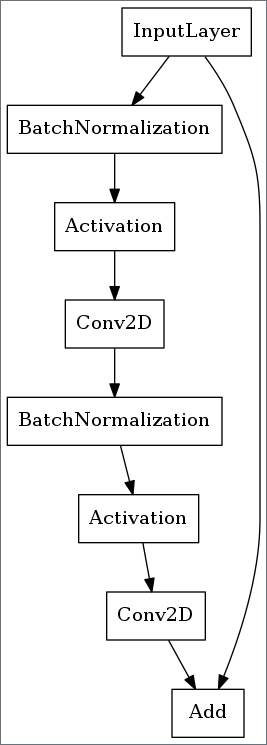

In [13]:
def residual_unit(layer):
    '''
    Input(s): layer - conv layer before this res unit
    
    Output(s): ResUnit layer - implemented as described in the paper
    '''
    step1 = tf.layers.batch_normalization(layer)
    step2 = tf.nn.relu(step1)
    step3 = conv2d_custom(step2, 3, 32, 32, activation=None, max_pool=False) #32 number of feautres is hyperparam
    step4 = tf.layers.batch_normalization(step3)
    step5 = tf.nn.relu(step4)
    step6 = conv2d_custom(step5, 3, 32, 32, activation=None, max_pool=False)
    return layer + step6

/bin/sh: 1: Syntax error: word unexpected (expecting ")")


In [2]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [3]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))